In [1]:
import numpy as np
import geopandas as gpd
from IPython.display import display
from shapely.geometry import Polygon
from utils import process_and_save_data
from model import EnhancedLandUsePredictionModel
from views import create_band_viewer, create_classification_viewer, create_spectral_indices_viewer, create_map_with_slider, analyze_time_series, plot_time_series, create_prediction_map_with_slider, create_prediction_viewer, visualize_predictions, ModelAnalysis


In [2]:
roi_coords = [
    [75.58679011123377, 26.725580815770467],
    [76.00152399795252, 26.725580815770467],
    [76.00152399795252, 27.08929110630265],
    [75.58679011123377, 27.08929110630265],
    [75.58679011123377, 26.725580815770467]
]

roi_polygon = Polygon(roi_coords)
roi_gdf = gpd.GeoDataFrame(index=[0], crs='EPSG:4326', geometry=[roi_polygon])



d:\Code\Python\CE712 Project - Integrating AI with Remote Sensing for Predictive Land Use Change Models\views.py:748: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


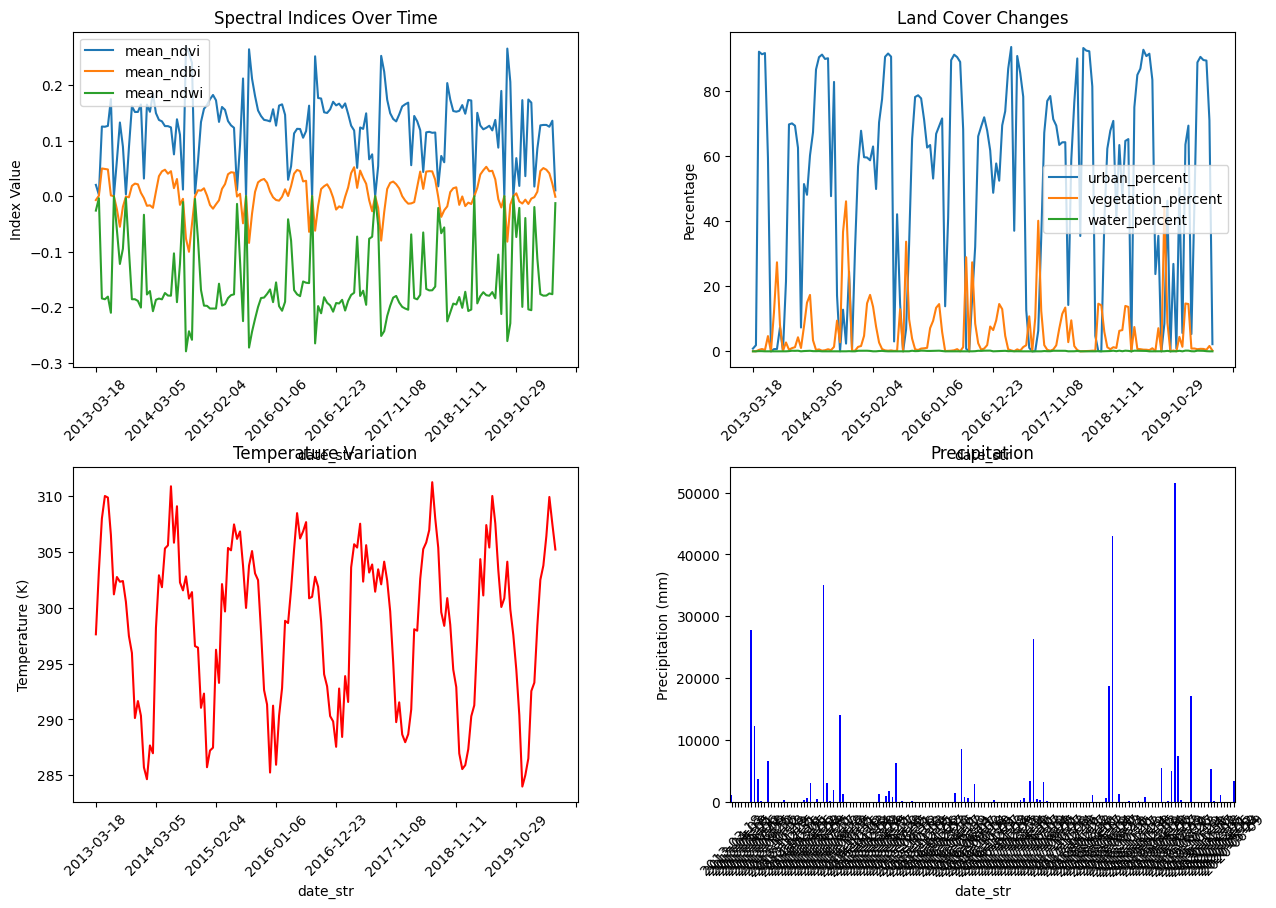

In [3]:
# Define file paths
data_dir = 'DataSet'
processed_dir = 'Processed_DataSet'
bounds = [[26.725580815770467, 75.58679011123377], 
         [27.08929110630265, 76.00152399795252]]

# Analyze time series
results = analyze_time_series(data_dir)

# Plot the time series results
plot_time_series(results)


In [4]:
all_processed_data = process_and_save_data(data_dir, processed_dir)


Processing new data...


In [5]:
band_viewer = create_band_viewer('DataSet')
display(band_viewer)


In [6]:
spectral_viewer = create_spectral_indices_viewer(all_processed_data)
display(spectral_viewer)


In [7]:
classification_viewer = create_classification_viewer(all_processed_data)
display(classification_viewer)


In [8]:
Map = create_map_with_slider(all_processed_data, bounds, roi_gdf)
Map


Map(center=[26.907436, 75.794157], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sear…

In [9]:

model = EnhancedLandUsePredictionModel(
        spatial_smoothing=1.0,
        window_size=3,
        n_estimators=50
    )

model.fit(all_processed_data, verbose=True, batch_size=10)

model.save_model('land_use_model.joblib')



Processing data with combined vegetation classes...
Starting model training...

Processing batch 1...

Processing batch 2...

Processing batch 3...

Processing batch 4...

Processing batch 5...

Processing batch 6...

Processing batch 7...

Processing batch 8...

Processing batch 9...

Processing batch 10...

Processing batch 11...

Processing batch 12...

Processing batch 13...

Processing batch 14...

Processing batch 15...

Processing batch 16...

Training completed:
Samples processed: 316,242,080
Observed classes: [np.int32(0), np.int32(1), np.int32(2), np.int32(3)]

Class distribution:
Class 0 (Barren Land): 130,636,791 samples (41.3%)
Class 1 (Vegetation): 17,907,578 samples (5.7%)
Class 2 (Urban): 167,488,494 samples (53.0%)
Class 3 (Water): 209,217 samples (0.1%)
Model saved to: land_use_model.joblib


In [10]:
model = EnhancedLandUsePredictionModel.load_model('land_use_model.joblib')


Model loaded from: land_use_model.joblib


In [11]:
predictions = model.predict_future(
        historical_window=all_processed_data[-24:],
        steps=3,
        verbose=True
    )

Processing historical data...

Generating 3 future predictions...

Generating prediction for step 1/3
Feature matrix shape: (2080540, 15)
Generated prediction for 2020-07-09
Unique predicted classes: [0 1 2]
Mean confidence: 0.984

Generating prediction for step 2/3
Feature matrix shape: (2080540, 15)
Generated prediction for 2020-08-08
Unique predicted classes: [0 1 2]
Mean confidence: 1.000

Generating prediction for step 3/3
Feature matrix shape: (2080540, 15)
Generated prediction for 2020-09-07
Unique predicted classes: [0 1 2]
Mean confidence: 0.988


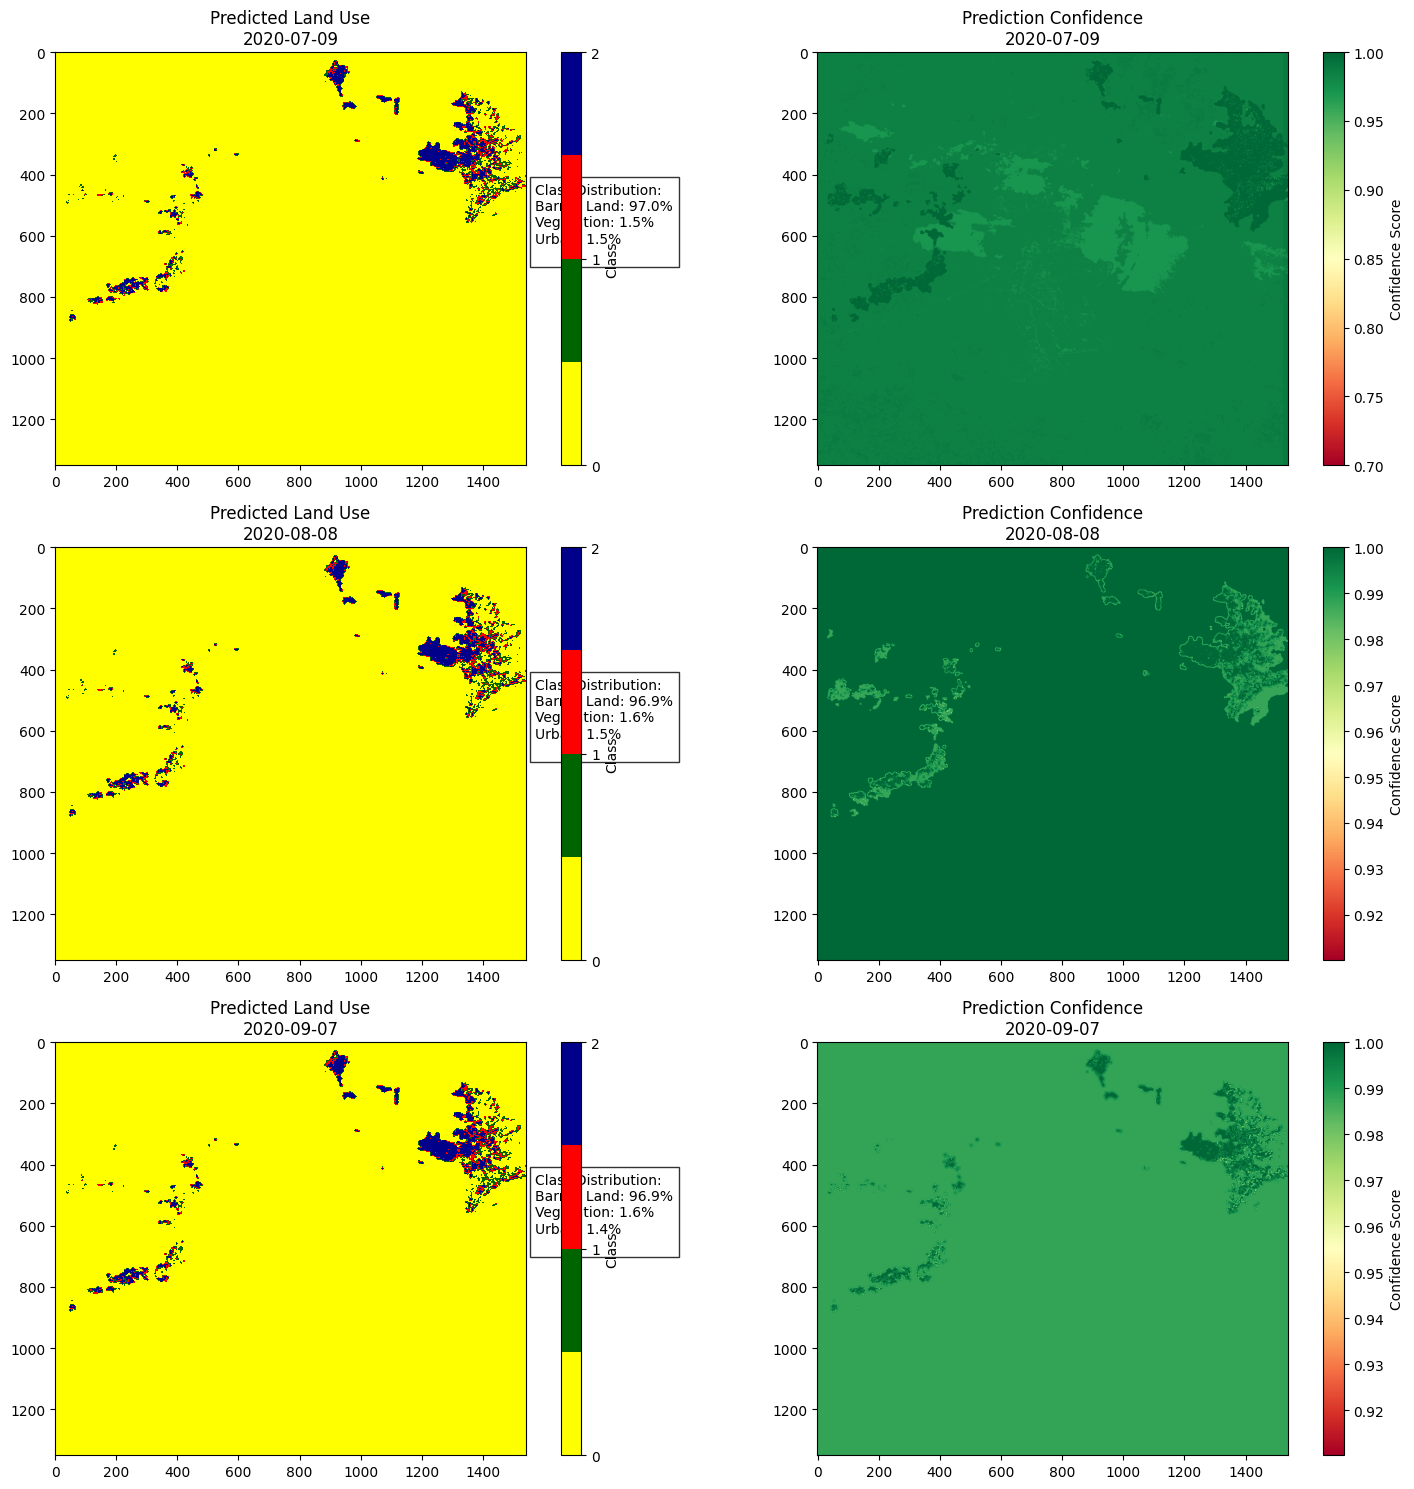

In [12]:
model.plot_prediction_results(predictions)

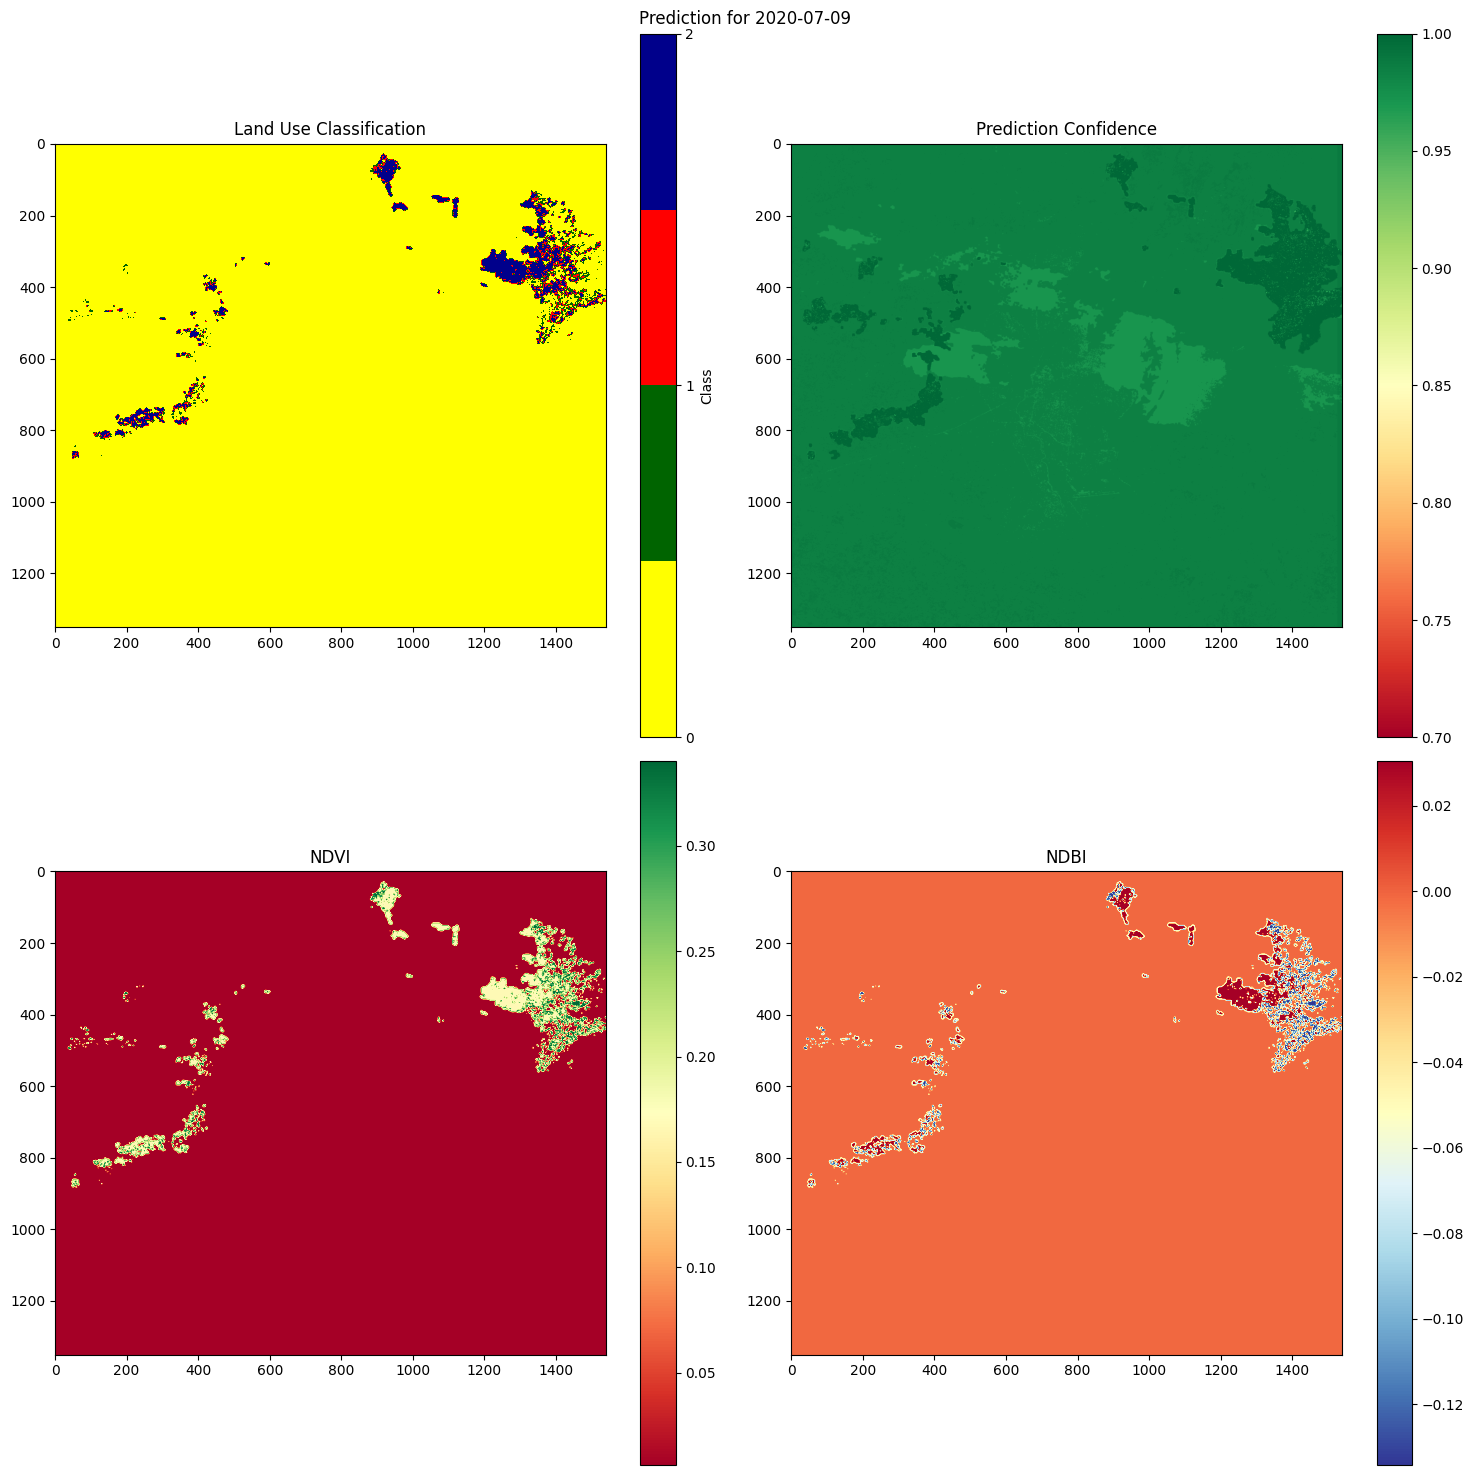

In [13]:
model.plot_prediction(predictions[0])

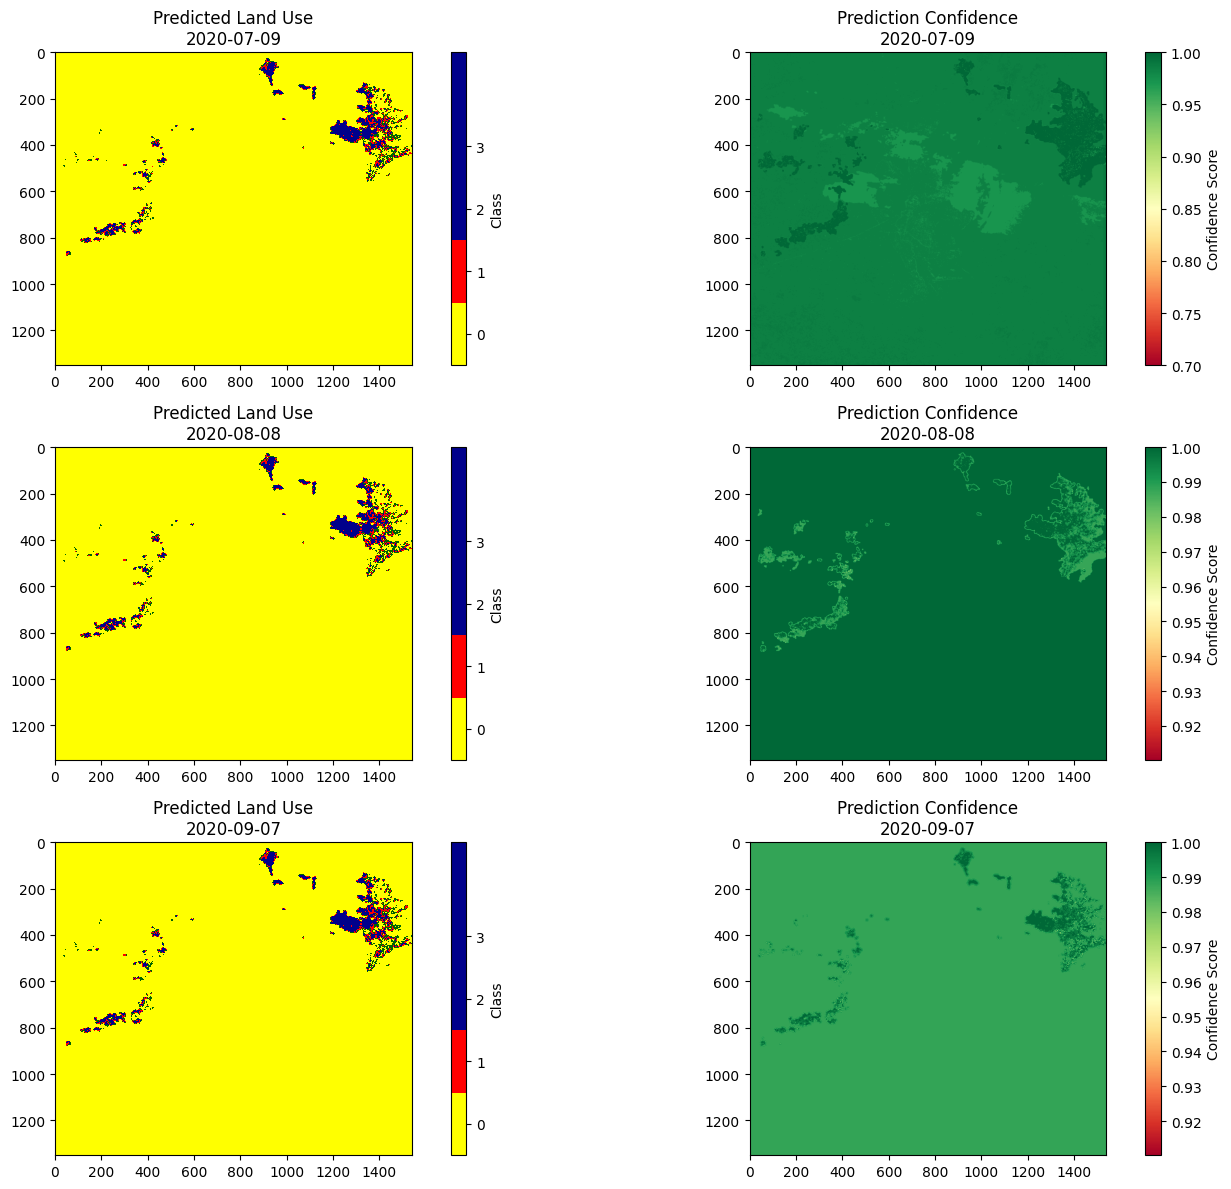

In [14]:
visualize_predictions(predictions)

In [15]:
for pred in predictions:
    print(f"\nPrediction for {pred['date_str']}:")
    unique, counts = np.unique(pred['classification'], return_counts=True)
    for cls, count in zip(unique, counts):
        print(f"Class {cls} ({model.class_mapping[cls]}): {count} pixels")
    print(f"Mean confidence: {np.mean(pred['confidence']):.3f}")


Prediction for 2020-07-09:
Class 0 (Barren Land): 2017114 pixels
Class 1 (Vegetation): 31950 pixels
Class 2 (Urban): 31476 pixels
Mean confidence: 0.984

Prediction for 2020-08-08:
Class 0 (Barren Land): 2017013 pixels
Class 1 (Vegetation): 33015 pixels
Class 2 (Urban): 30512 pixels
Mean confidence: 1.000

Prediction for 2020-09-07:
Class 0 (Barren Land): 2017023 pixels
Class 1 (Vegetation): 33444 pixels
Class 2 (Urban): 30073 pixels
Mean confidence: 0.988


In [16]:
analyzer = ModelAnalysis()

In [17]:
print("\nAnalyzing class distribution...")
class_dist = analyzer.analyze_class_distribution(predictions)
print(class_dist)
        
print("\nAnalyzing prediction confidence...")
confidence_analysis = analyzer.analyze_confidence(predictions)
print(confidence_analysis)
        
print("\nAnalyzing spatial changes...")
spatial_changes = analyzer.analyze_spatial_changes(predictions)
print(spatial_changes)


Analyzing class distribution...
         date  total_pixels  class_0_percent  class_1_percent  class_2_percent
0  2020-07-09       2080540        96.951465         1.535659         1.512876
1  2020-08-08       2080540        96.946610         1.586848         1.466542
2  2020-09-07       2080540        96.947091         1.607467         1.445442

Analyzing prediction confidence...
         date  mean_confidence  min_confidence  max_confidence  std_confidence
0  2020-07-09         0.984198        0.700000             1.0        0.004971
1  2020-08-08         0.999568        0.910134             1.0        0.002570
2  2020-09-07         0.988100        0.910219             1.0        0.002247

Analyzing spatial changes...
    from_date     to_date  change_percentage  pixels_changed  total_pixels
0  2020-07-09  2020-08-08           0.223259            4645       2080540
1  2020-08-08  2020-09-07           0.098100            2041       2080540


In [18]:
total_data = all_processed_data + predictions

In [19]:
P_map = create_prediction_map_with_slider(total_data, bounds, roi_gdf)
P_map

Map(center=[26.907436, 75.794157], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sear…

In [20]:
P_view = create_prediction_viewer(total_data)
display(P_view)